In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np

In [4]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *

from keras.datasets import fashion_mnist, mnist

Using TensorFlow backend.


In [5]:
from utils import *

# Loading and preparing data

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

In [8]:
BATCH_SIZE = 32
N_EPOCH = 128

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 256

# Simple AE

### Definition and training

In [9]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)
           
encoder = Model(inp_e, e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Stacking all together
inp_x = Input((INPUT_DIM,))
reconstruction = decoder(encoder(inp_x))

trainable = Model(inp_x, reconstruction)
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

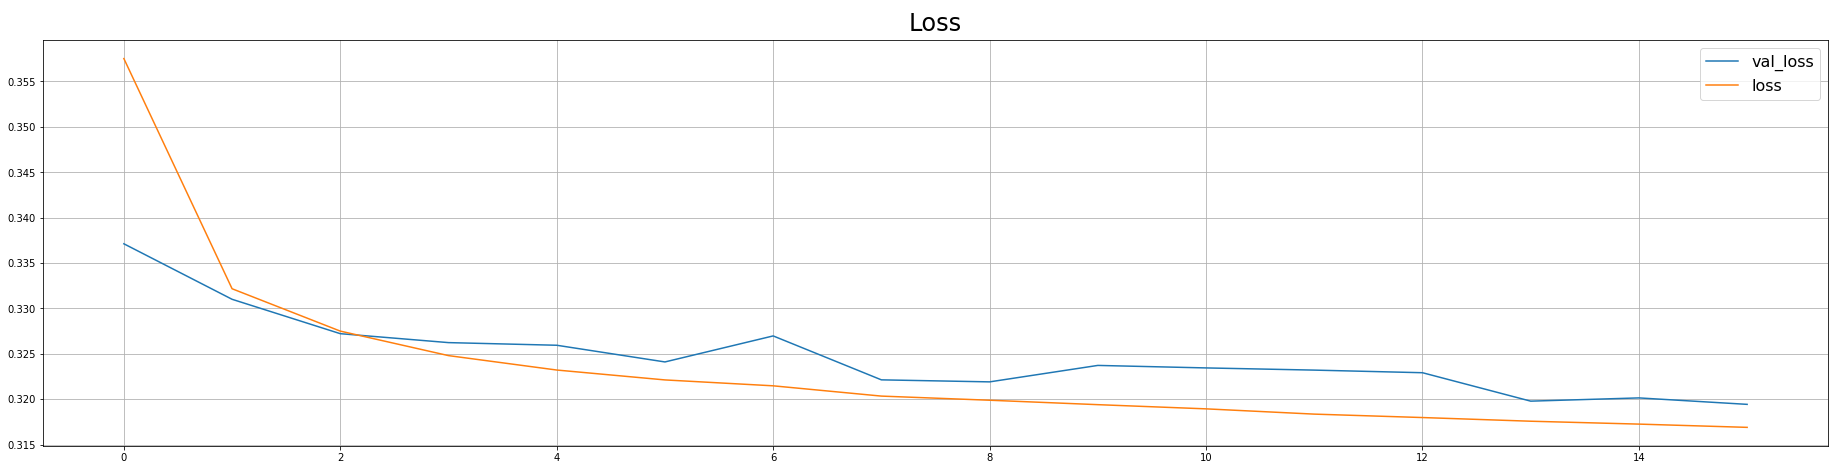

In [10]:
trainable.fit(x=x_train, y=x_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=0, validation_data=(x_test, x_test), shuffle=True,
              callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'loss', 'constants':{}},))])

### Results

In [11]:
n_points = 20
z_space_range = (-10, 10)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z2) for z1 in z_values_range for z2 in z_values_range[::-1]])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

In [12]:
z_space_code = encoder.predict(x_test)
z1, z2 = z_space_code.T

In [13]:
# check statistics
z_space_code.mean(), z_space_code.std()

(1.3330508, 9.061543)

In [14]:
# clip distant values to keep plot informative
z1 = np.clip(z1, -3 * z1.std(), 3 * z1.std())
z2 = np.clip(z2, -3 * z2.std(), 3 * z2.std())

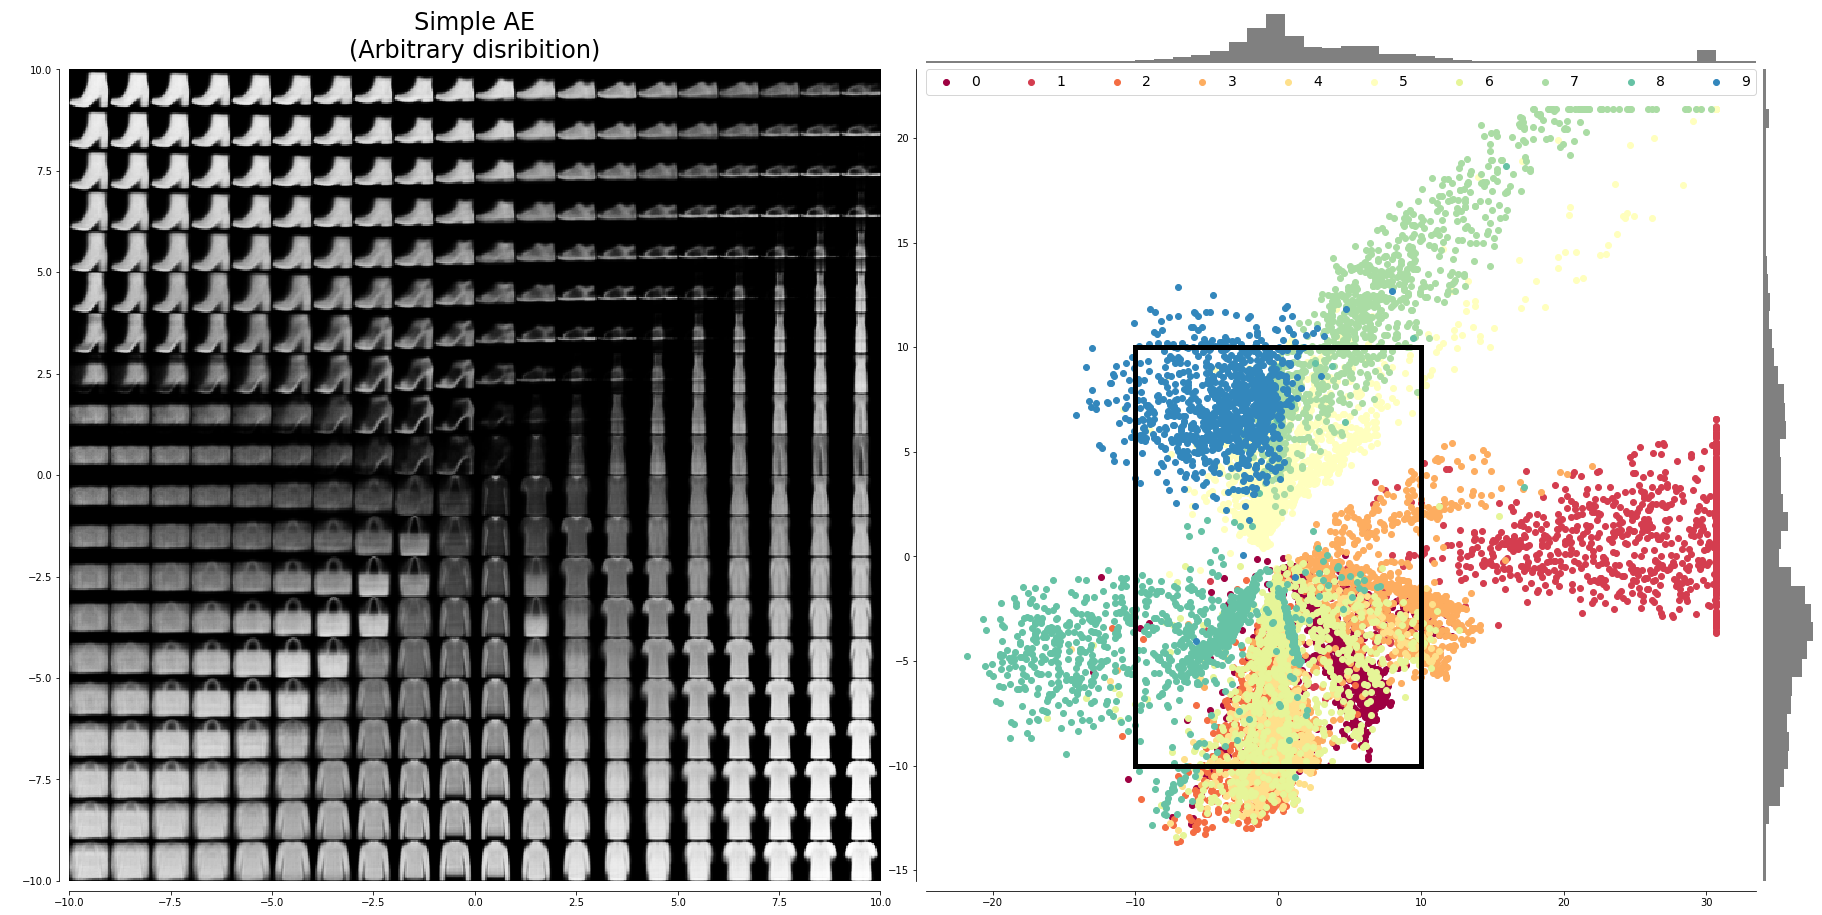

In [15]:
visualize('Simple AE\n(Arbitrary disribition)', z_space_image, z_space_range, z1, z2, y_test)

# Deterministic AAE

### Definition and training

In [16]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)
           
encoder = Model(inp_e, e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder(inp_x))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder(inp_x)))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [17]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [18]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

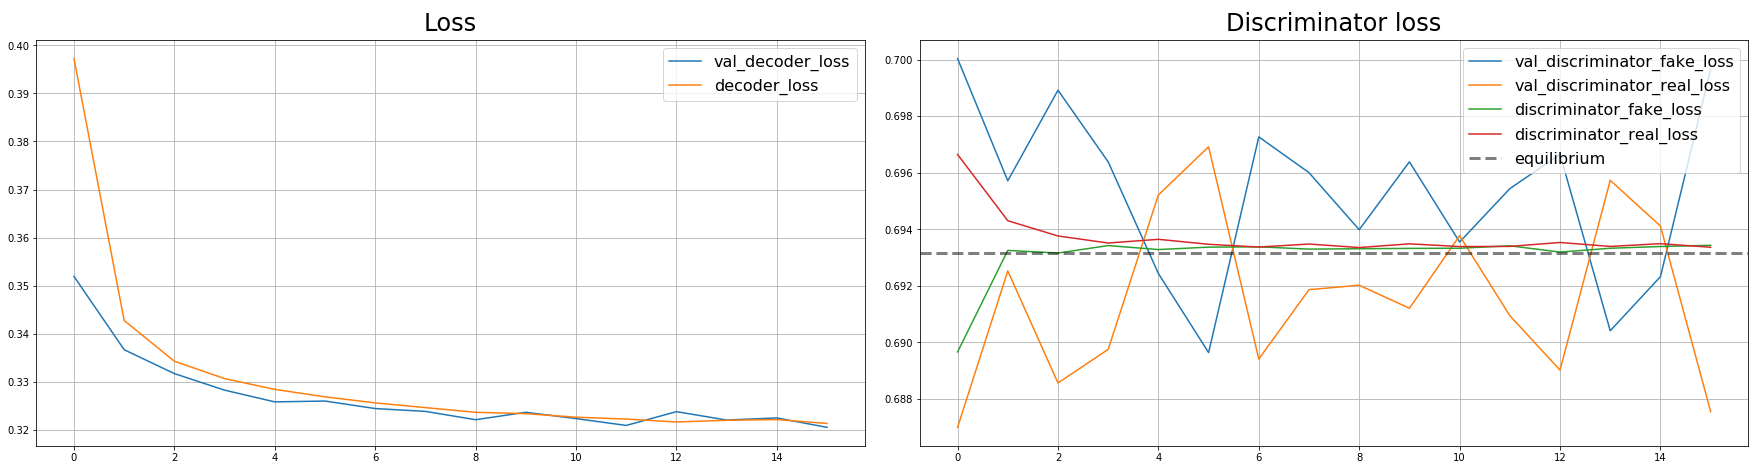

In [19]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

In [20]:
n_points = 20
z_space_range = (-1, 1)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z2) for z1 in z_values_range for z2 in z_values_range[::-1]])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

In [21]:
z_space_code = encoder.predict(x_test)
z1, z2 = z_space_code.T

<br>Mean is near zero, standard deviation is near one -- looks like our prior distribution (standard normal)

In [72]:
z_space_code.mean(), z_space_code.std()

(0.4975283, 0.3603956)

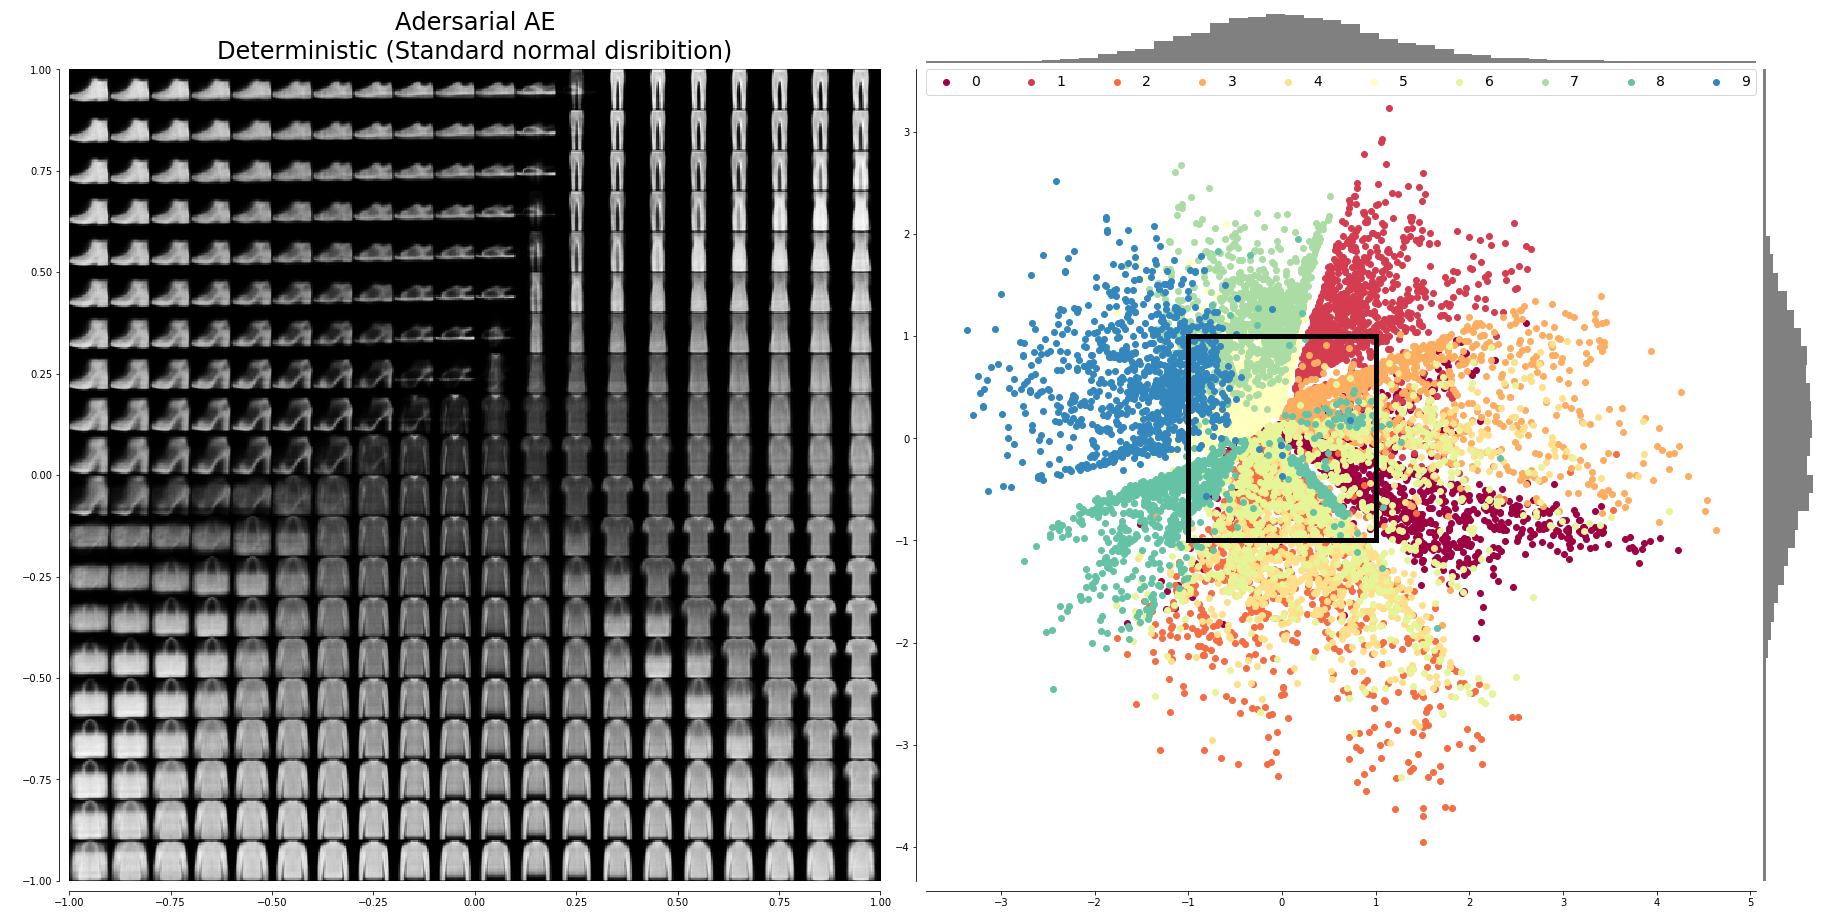

In [23]:
visualize('Adersarial AE\nDeterministic (Standard normal disribition)', z_space_image, z_space_range, z1, z2, y_test)

# Gaussian posterior

### Definition and training

In [24]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)

# Reparametrization trick
z_mean = Dense(LATENT_DIM)(e)
z_log_sigma = Dense(LATENT_DIM)(e)
z_code = Lambda(lambda x: x[0] + K.exp(x[1]) * K.random_normal(shape=K.shape(x[0])))([z_mean, z_log_sigma])
           
encoder = Model(inp_e, [z_code, z_mean, z_log_sigma], name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder(inp_x)[0])
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder(inp_x)[0]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [25]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [26]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

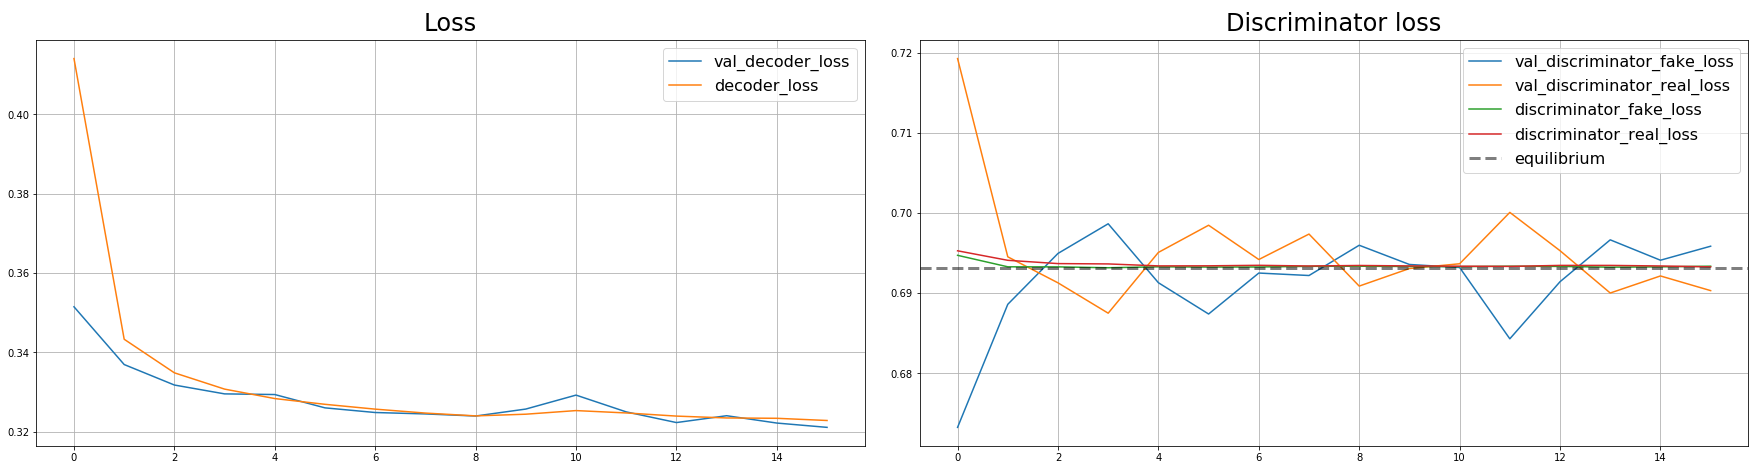

In [27]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

In [28]:
n_points = 20
z_space_range = (-1, 1)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z2) for z1 in z_values_range for z2 in z_values_range[::-1]])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

In [29]:
z_space_code, z_mean_test, z_log_sigma_test = encoder.predict(x_test)
z1, z2 = z_space_code.T

<br>Statistics of our latent dimension looks fine (like standard normal) ...

In [32]:
z_space_code.mean(), z_space_code.std()

(-0.008636879, 1.0104487)

<br>... but explicit parameters for reparametrization trick for standard normal is wrong: std is near zero.

In [70]:
z_mean_test.mean(), z_mean_test.std()

(-0.00864084, 1.0104482)

In [71]:
np.exp(z_log_sigma_test).mean(), np.exp(z_log_sigma_test).std()

(7.060624e-05, 0.00033897758)

<br>Kullback–Leibler divergence is huge.<br>It seems like AAE with gaussian prior doen't behave similar to regular VAE under the hood, thus can not be used instead.

In [43]:
np.mean(-0.5 * np.mean(1 + z_log_sigma_test - np.square(z_mean_test) - np.exp(z_log_sigma_test), axis=-1))

8.31505

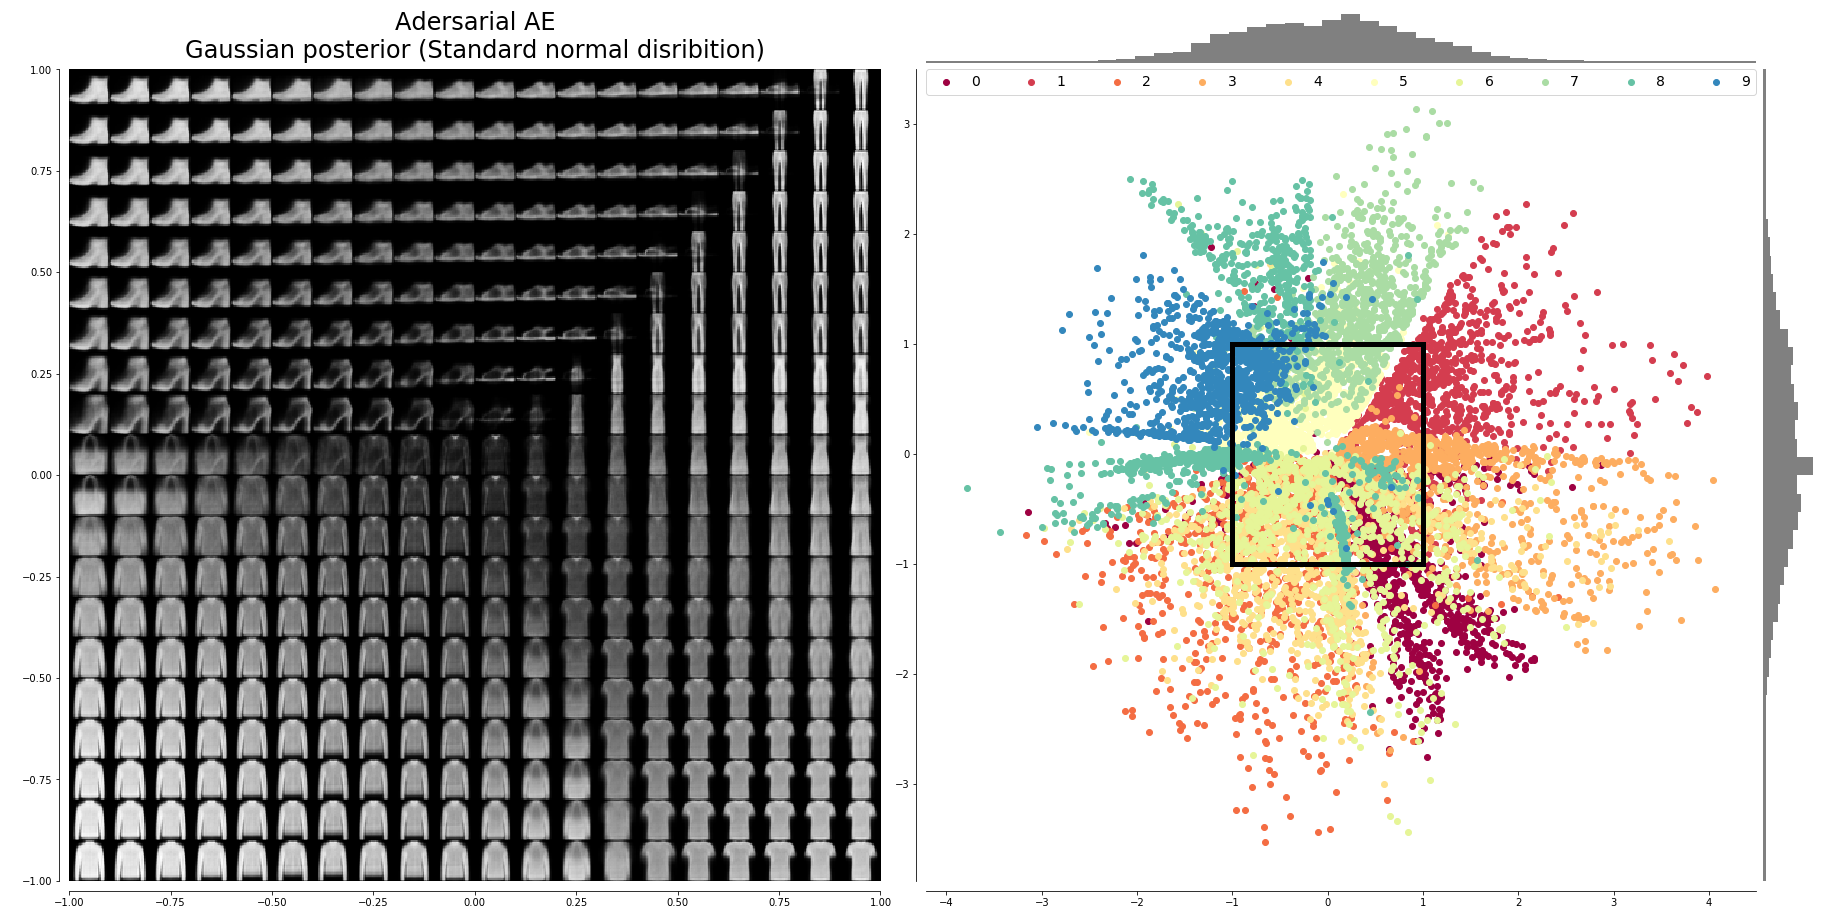

In [33]:
visualize('Adersarial AE\nGaussian posterior (Standard normal disribition)', z_space_image, z_space_range, z1, z2, y_test)

# Universal approximator posterior (Beta)

### Definition and training

In [34]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='sigmoid')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder([inp_x, inp_noise]))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder([inp_x, inp_noise])))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, inp_noise, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [35]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                prior_noise = np.random.beta(0.5, 0.5, (batch_size, LATENT_DIM))
                
                yield [X, input_noise, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [36]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

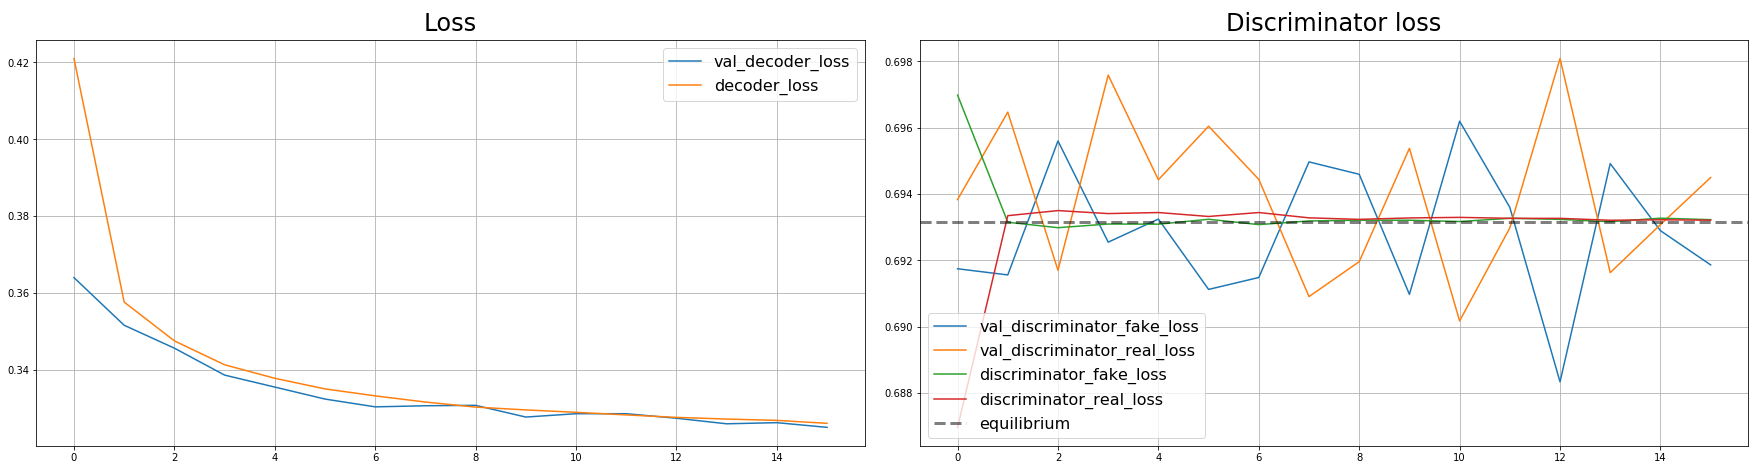

In [37]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

In [38]:
n_points = 20
z_space_range = (0, 1)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z_space_range[1] - z2) for z1 in z_values_range for z2 in z_values_range])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

In [39]:
z_space_code = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
z1, z2 = z_space_code.T

<br>Statistics...

In [40]:
z_space_code.mean(), z_space_code.std()

(0.4975283, 0.3603956)

Just double check that we have similar distributions. (If you trust numbers more than plots :)

In [67]:
from scipy.stats import entropy
Q, _ = np.histogram(z_space_code, bins=100, range=(0, 1), density=True)
P, _ = np.histogram(np.random.beta(0.5, 0.5, (z_space_code.shape[0], LATENT_DIM)), bins=100, range=(0, 1), density=True)
entropy(P, Q)

0.011765781688599005

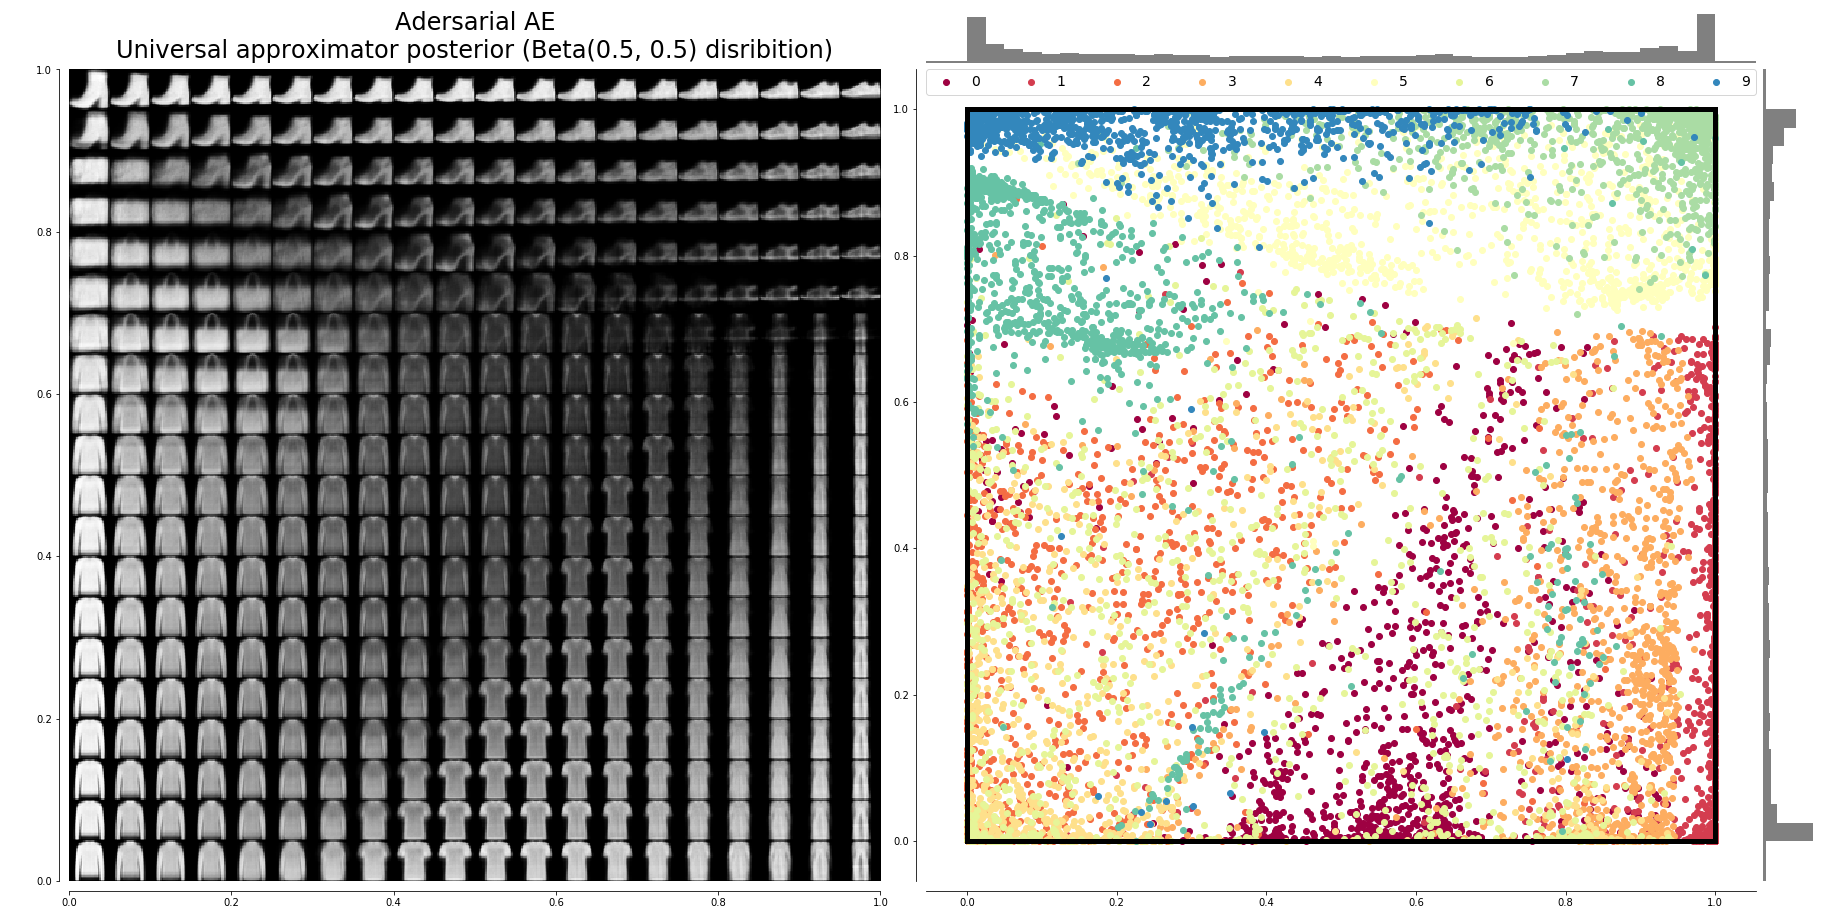

In [41]:
visualize('Adersarial AE\nUniversal approximator posterior (Beta(0.5, 0.5) disribition)', z_space_image, z_space_range, z1, z2, y_test)